In [1]:
import os
import copy
# from coffea import hist
import hist
from coffea import util
import numpy as np
import itertools
import pandas as pd
from scipy.misc import derivative
import scipy.optimize as sciop
import scipy.special as scisp
from scipy.interpolate import make_interp_spline
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import warnings
import re # regular expressions
# warnings.filterwarnings("ignore")
import mplhep as hep
from hist.intervals import ratio_uncertainty

In [2]:
btag = 'MediumBTag'
year = '2017'
runB = False

In [3]:
directory = 'CoffeaOutputsForTriggerAnalysis/SingleMu/'+btag+'/'+year+'/'
directory1 = 'CoffeaOutputsForTriggerAnalysis/SingleMu/'+btag+'/2016/'
directory2 = 'CoffeaOutputsForTriggerAnalysis/SingleMu/'+btag+'/2017/'
directory3 = 'CoffeaOutputsForTriggerAnalysis/SingleMu/'+btag+'/2018/'
directory4 = 'CoffeaOutputsForTriggerAnalysis/SingleMu/'+btag+'/20161718/'

In [4]:
Data_out_2016 = util.load(directory1+'TTbarRes_0l_SingleMu2016_Data_TriggerAnalysis.coffea')
Data_out_2017 = util.load(directory2+'TTbarRes_0l_SingleMu2017_Data_TriggerAnalysis.coffea')
Data_out_2018 = util.load(directory3+'TTbarRes_0l_SingleMu2018_Data_TriggerAnalysis.coffea')
Data_out = util.load(directory+'TTbarRes_0l_SingleMu'+year+'_Data_TriggerAnalysis.coffea')
if runB:
    Data_out = util.load(directory+'TTbarRes_0l_SingleMu'+year+'_Data_TriggerAnalysis.coffea')

In [5]:
print("-------Unweighted SingleMu"+year+"_Data--------")
for i,j in Data_out['cutflow'].items():        
    print( '%20s : %12d' % (i,j) )

-------Unweighted SingleMu2017_Data--------
          all events :    154618774
events with Loose Jet ID :     10890425
events with pT,y Cut :       751803
events with two FatJets :       289358
events with >= oneTTbar :       289358
events with dPhi Cut :       144402
events with Good Subjets :       140083
events with jets cond1 :        34646
events with jets cond2 :        36525
events with jets cond3 :        52619
events with jets cond4 :        54834
events with jets Denom cond :        79297
jets cond1 with ak4cut :       157479
jets cond2 with ak4cut :       163768
jets cond3 with ak4cut :       228534
jets cond4 with ak4cut :       237447
jets Denom with ak4cut :       316518
               NoCut :        79297
                >=1t :        27786


In [6]:
def mkdir_p(mypath):
    '''Creates a directory. equivalent to using mkdir -p on the command line'''

    from errno import EEXIST
    from os import makedirs,path

    try:
        makedirs(mypath)
    except OSError as exc: # Python >2.5
        if exc.errno == EEXIST and path.isdir(mypath):
            pass
        else: raise

In [7]:
def DoesDirectoryExist(mypath): #extra precaution (Probably overkill...)
    '''Checks to see if Directory exists before running mkdir_p'''
    import os.path
    from os import path
    
    if path.exists(mypath):
        pass
    else:
        mkdir_p(mypath)

In [8]:
import matplotlib.pyplot as plt
import warnings
import re # regular expressions
warnings.filterwarnings("ignore")

# ---- Reiterate categories ---- #
# ttagcats = ["NoCut", ">=1t"]
ttagcats = [0, 1]

In [9]:
def plotratio(numerator, denominator, ax=None, histtype='errorbar', marker='.', markersize=5., color='k', alpha=0.1):
    NumeratorAxes = numerator.axes
    DenominatorAxes = denominator.axes
    
    # integer number of bins in this axis #
    NumeratorAxis1_BinNumber = NumeratorAxes[0].size - 3 # Subtract 3 to remove overflow
    
    DenominatorAxis1_BinNumber = DenominatorAxes[0].size - 3 
    
    if(NumeratorAxis1_BinNumber != DenominatorAxis1_BinNumber):
        raise Exception('Numerator and Denominator axes are different sizes; Cannot perform division.')
        
    ratio = numerator / denominator.values()

    err_up, err_down = ratio_uncertainty(numerator.values(), denominator.values(), 'efficiency')
    yerror = [err_up, err_down]

#     for ra, u, d in zip(ratio, err_up, err_down):
#         print(f'{ra} +{u} -{d}\n')
#     print('=================================================\n')
    
    if histtype == 'errorbar':
        return hep.histplot(ratio, ax=ax, histtype=histtype, marker=marker, markersize=markersize, color=color, 
                            yerr=yerror)
    elif histtype == 'fill':
        return hep.histplot(ratio, ax=ax, histtype=histtype, color=color, alpha=alpha, lw=5., 
                           yerr=yerror)
    else:
        return hep.histplot(ratio, ax=ax, histtype=histtype, color=color, yerr=yerror)

In [10]:
def plotratio2d(numerator, denominator, ax=None, cmap='Blues', cbar=True):
    NumeratorAxes = numerator.axes
    DenominatorAxes = denominator.axes
    
    # integer number of bins in this axis #
    NumeratorAxis1_BinNumber = NumeratorAxes[0].size - 3 # Subtract 3 to remove overflow
    NumeratorAxis2_BinNumber = NumeratorAxes[1].size - 3
    
    DenominatorAxis1_BinNumber = DenominatorAxes[0].size - 3 
    DenominatorAxis2_BinNumber = DenominatorAxes[1].size - 3 
    
    if(NumeratorAxis1_BinNumber != DenominatorAxis1_BinNumber 
       or NumeratorAxis2_BinNumber != DenominatorAxis2_BinNumber):
        raise Exception('Numerator and Denominator axes are different sizes; Cannot perform division.')
    # else:
    #     Numerator = numerator.to_hist()
    #     Denominator = denominator.to_hist()
        
    ratio = numerator / denominator.values()

    return hep.hist2dplot(ratio, ax=ax, cmap=cmap, norm=colors.Normalize(0.,1.), cbar=cbar)

In [11]:
maindirectory = os.getcwd() 

# Plots

In [12]:
SaveDirectory = maindirectory + '/TriggerAnalysisPlots/'+btag+'/'+year+'/' 
SaveDirectory4 = maindirectory + '/TriggerAnalysisPlots/'+btag+'/20161718/' # Directory where trigger analysis plots will be saved
DoesDirectoryExist(SaveDirectory) # no need to create the directory several times if it exists already

# Combination of Triggers (Conditions) Plotted as Functions of AK4 Jet $H_T$, AK8 $M_{SD}$ and Invariant $t\bar{t}$ Mass

In [13]:
# Numerator1 = Data_num['condition1_numerator']['SingleMu'+year+'_Data', cat, :, sum]
# Denominator = Data_num['condition_denominator']['SingleMu'+year+'_Data', cat, :, sum]

# for cat in ttagcats:
#     #---- Histogram Window Config. ----# 
#     plt.rcParams.update({
#     'font.size': 14,
#     'axes.titlesize': 18,
#     'axes.labelsize': 18,
#     'xtick.labelsize': 12,
#     'ytick.labelsize': 12
#     })
    
#     fig, ax = plt.subplots(
#         nrows=1,
#         ncols=1,
#         figsize=(7,7),
#         #sharey=True
#         sharex=True
#     )
    
#     fig.subplots_adjust(hspace=.07)
#     if runB:
#         Denominator_ht = Data_out['condition_denominator']['SingleMu'+year+'_Data', cat, :, sum, sum]
#     else:
#         Denominator_ht = Data_out['condition_denominator']['SingleMu'+year+'_Data', cat, :, sum, sum]
    
#     if year == '2016':
#         # ------------------------------------------------------------------------------------- #
#         Numerator1_ht = Data_out['condition1_numerator']['SingleMu'+year+'_Data', cat, :, sum, sum]
#         Numerator2_ht = Data_out['condition2_numerator']['SingleMu'+year+'_Data', cat, :, sum, sum]
#         Numerator3_ht = Data_out['condition3_numerator']['SingleMu'+year+'_Data', cat, :, sum, sum]
#         Numerator4_ht = Data_out['condition4_numerator']['SingleMu'+year+'_Data', cat, :, sum, sum]

#         EffPlot1_ht = plotratio(Numerator1_ht, Denominator_ht, ax, 'errorbar', '_', 7., 'k')
#         EffPlot2_ht = plotratio(Numerator2_ht, Denominator_ht, ax, 'errorbar', '_', 10., 'g')
#         EffPlot3_ht = plotratio(Numerator3_ht, Denominator_ht, ax, 'errorbar', '_', 6., 'r')
#         EffPlot4_ht = plotratio(Numerator4_ht, Denominator_ht, ax, 'errorbar', '_', 10., 'b')

#         print(Numerator4_ht / Denominator_ht.values())
    
#     elif year == '2017' and runB:
#         # ------------------------------------------------------------------------------------- #
#         Numerator1_ht = Data_out['condition1_numerator']['SingleMu'+year+'_Data', cat, :, sum, sum]
#         Numerator2_ht = Data_out['condition2_numerator']['SingleMu'+year+'_Data', cat, :, sum, sum]
        
#         EffPlot1_ht = plotratio(Numerator1_ht, Denominator_ht, ax, 'errorbar', '_', 10., 'k')
#         EffPlot2_ht = plotratio(Numerator2_ht, Denominator_ht, ax, 'errorbar', '_', 10., 'g')        
        
 
#         print(Numerator2_ht / Denominator_ht.values())
        
#     elif year == '2017' and not runB:
        
#         # ------------------------------------------------------------------------------------- #
#         Numerator1_ht = Data_out['condition1_numerator']['SingleMu'+year+'_Data', cat, :, sum, sum]
#         Numerator2_ht = Data_out['condition2_numerator']['SingleMu'+year+'_Data', cat, :, sum, sum]
#         Numerator3_ht = Data_out['condition3_numerator']['SingleMu'+year+'_Data', cat, :, sum, sum]
#         Numerator4_ht = Data_out['condition4_numerator']['SingleMu'+year+'_Data', cat, :, sum, sum]
        
#         EffPlot1_ht = plotratio(Numerator1_ht, Denominator_ht, ax, 'errorbar', '_', 10., 'k')
#         EffPlot2_ht = plotratio(Numerator2_ht, Denominator_ht, ax, 'errorbar', '_', 10., 'g')
#         EffPlot3_ht = plotratio(Numerator3_ht, Denominator_ht, ax, 'errorbar', '_', 10., 'r')
#         EffPlot4_ht = plotratio(Numerator4_ht, Denominator_ht, ax, 'errorbar', '_', 10., 'b')

#         print(Numerator4_ht / Denominator_ht.values())
        
#     else: # year 2018
        
#         # ------------------------------------------------------------------------------------- #
#         Numerator1_ht = Data_out['condition1_numerator']['SingleMu'+year+'_Data', cat, :, sum, sum]
#         Numerator2_ht = Data_out['condition2_numerator']['SingleMu'+year+'_Data', cat, :, sum, sum]
#         Numerator3_ht = Data_out['condition3_numerator']['SingleMu'+year+'_Data', cat, :, sum, sum]
 
#         EffPlot1_ht = plotratio(Numerator1_ht, Denominator_ht, ax, 'errorbar', '_', 10., 'k')
#         EffPlot2_ht = plotratio(Numerator2_ht, Denominator_ht, ax, 'errorbar', '_', 10., 'g')
#         EffPlot3_ht = plotratio(Numerator3_ht, Denominator_ht, ax, 'errorbar', '_', 10., 'r')

#         print(Numerator3_ht / Denominator_ht.values())
        
 
#     if year == '2016':
#         leg = ax.legend(labels=[r'${\mathrm{Condition_1}}$',r'${\mathrm{Condition_2}}$', r'${\mathrm{Condition_3}}$', r'${\mathrm{Condition_4}}$'], bbox_to_anchor=(0.99, 0.8),fontsize = 10, loc='upper right')
#     elif year == '2017'and runB:
#         leg = ax.legend(labels=[r'${\mathrm{Condition_1}}$',r'${\mathrm{Condition_2}}$'],bbox_to_anchor=(0.99, 0.8),fontsize = 10, loc='upper right')
#     elif year == '2017'and not runB:
#         leg = ax.legend(labels=[r'${\mathrm{Condition_1}}$',r'${\mathrm{Condition_2}}$', r'${\mathrm{Condition_3}}$', r'${\mathrm{Condition_4}}$'], bbox_to_anchor=(0.99, 0.8),fontsize = 10, loc='upper right')
#     else:
#         leg = ax.legend(labels=[r'${\mathrm{Condition_1}}$',r'${\mathrm{Condition_2}}$', r'${\mathrm{Condition_3}}$'], bbox_to_anchor=(0.99, 0.8),fontsize = 10, loc='upper right')


#     ax.set_xlim(750, 1800)
#     ax.set_ylim(bottom=0., top=1.05)
#     ax.set_ylabel('Trigger Efficiency', fontsize = 14, loc = "top")
#     ax.set_xlabel('H$_{\mathrm{T}}$ [GeV]', fontsize = 14, loc = "right")
#     ax.grid(axis="x", color="k", alpha=.2, linewidth=1, linestyle=":")
#     ax.grid(axis="y", color="k", alpha=.2, linewidth=1, linestyle=":")
#     ax.tick_params(direction='in', top=True, right=True)

#     Cat_legend_entry = None
#     if cat == 0:
#         if year == '2016':
#             Cat_legend_entry = "Datasets: 2016 B-H\nAK8 jets: ${\mathrm{|\Delta\phi|}}$ > 2.1, p${\mathrm{_T}}$ > 400 GeV"
#             fnc = '_noSD'
#         elif year == '2017' and runB:
#             Cat_legend_entry = "Datasets: 2017 B-F\nAK8 jets: ${\mathrm{|\Delta\phi|}}$ > 2.1, p$_{\mathrm{T}}$ > 400 GeV"
#             fnc = '_noSD'
#         elif year == '2017' and not runB:
#             Cat_legend_entry = "Datasets: 2017 C-F\nAK8 jets: ${\mathrm{|\Delta\phi|}}$ > 2.1, p$_{\mathrm{T}}$ > 400 GeV"
#             fnc = '_noSD'
#         else:
#             Cat_legend_entry = "Datasets: 2018 A-D\nAK8 jets: ${\mathrm{|\Delta\phi|}}$ > 2.1, p$_{\mathrm{T}}$ > 400 GeV"
#             fnc = '_noSD'
#     else:
#         if year == '2016':
#             Cat_legend_entry = "Datasets: 2016 B-H\nAK8 jets: ${\mathrm{|\Delta\phi|}}$ > 2.1, p${\mathrm{_T}}$ > 400 GeV \n1+jet: 105 GeV < M${\mathrm{_{PUPPI+SD}}}$ < 210 GeV"
#             fnc = '_SD'
#         elif year == '2017' and runB:
#             Cat_legend_entry = "Datasets: 2017 B-F\nAK8 jets: ${\mathrm{|\Delta\phi|}}$ > 2.1, p${\mathrm{_T}}$ > 400 GeV \n1+jet: 105 GeV < M${\mathrm{_{PUPPI+SD}}}$ < 210 GeV"
#             fnc = '_SD'
#         elif year == '2017' and not runB:
#             Cat_legend_entry = "Datasets: 2017 C-F\nAK8 jets: ${\mathrm{|\Delta\phi|}}$ > 2.1, p${\mathrm{_T}}$ > 400 GeV \n1+jet: 105 GeV < M${\mathrm{_{PUPPI+SD}}}$ < 210 GeV"
#             fnc = '_SD'
#         else:
#             Cat_legend_entry = "Datasets: 2018 A-D\nAK8 jets: ${\mathrm{|\Delta\phi|}}$ > 2.1, p${\mathrm{_T}}$ > 400 GeV \n1+jet: 105 GeV < M${\mathrm{_{PUPPI+SD}}}$ < 210 GeV"
#             fnc = '_SD'

#     leg2 = plt.text(0.38, 0.48, Cat_legend_entry,
#                 fontsize=12,
#                 style='normal',
#                 #horizontalalignment='right',
#                 #verticalalignment='top',
#                 transform=ax.transAxes
#                )
    

#     ax.text(0.002, 1.035, 'CMS',
#         verticalalignment='top', horizontalalignment='left',
#         transform=ax.transAxes,
#         color='black', fontsize=14, fontweight='bold')
    
#     ax.text(0.099, 1.030, 'Preliminary',
#         verticalalignment='top', horizontalalignment='left',
#         transform=ax.transAxes,
#         color='black', fontsize=12, style='normal')
    
#     if year == '2016':
#         ax.text(1.005, 1.039, '35.9 fb$^{-1} (13{\mathrm{TeV}})$',
#         verticalalignment='top', horizontalalignment='right',
#         transform=ax.transAxes,
#         color='black', fontsize=14, style='normal')
        
#     if year == '2017' and runB:
#         ax.text(1.005, 1.039, '41.5 fb$^{-1} (13{\mathrm{TeV}})$',
#         verticalalignment='top', horizontalalignment='right',
#         transform=ax.transAxes,
#         color='black', fontsize=14, style='normal')
        
#     if year == '2017' and not runB:
#         ax.text(1.005, 1.039, '36.7 fb$^{-1} (13{\mathrm{TeV}})$',
#         verticalalignment='top', horizontalalignment='right',
#         transform=ax.transAxes,
#         color='black', fontsize=14, style='normal')    
    
#     if year == '2018':
#         ax.text(1.005, 1.039, '59.7 fb$^{-1} (13{\mathrm{TeV}})$',
#         verticalalignment='top', horizontalalignment='right',
#         transform=ax.transAxes,
#         color='black', fontsize=14, style='normal')
    
    #filename = 'TriggerEffsHT' + fnc +'.png'
    # filename = 'TriggerEffsHT' + fnc +'_withB.png'
    # plt.savefig(SaveDirectory+filename, bbox_inches="tight")
    # print(SaveDirectory+filename)

In [14]:
# Numerator1 = Data_num['condition1_numerator']['SingleMu'+year+'_Data', cat, :, sum]
# Denominator = Data_num['condition_denominator']['SingleMu'+year+'_Data', cat, :, sum]

# for cat in ttagcats:
#     #---- Histogram Window Config. ----# 
#     plt.rcParams.update({
#     'font.size': 14,
#     'axes.titlesize': 18,
#     'axes.labelsize': 18,
#     'xtick.labelsize': 12,
#     'ytick.labelsize': 12
#     })
    
#     fig, ax = plt.subplots(
#         nrows=1,
#         ncols=1,
#         figsize=(7,7),
#         #sharey=True
#         sharex=True
#     ) 

    
#     fig.subplots_adjust(hspace=.07)
    
#     if runB:
#         Denominator_sd = Data_out['condition_denominator']['SingleMu'+year+'_Data', cat,  sum, :, sum]
#     else:
#         Denominator_sd = Data_out['condition_denominator']['SingleMu'+year+'_Data', cat, sum, :, sum]

    
#     if year == '2016':
#         # ------------------------------------------------------------------------------------- #
#         Numerator1_sd = Data_out['condition1_numerator']['SingleMu'+year+'_Data', cat, sum, :, sum]
#         Numerator2_sd = Data_out['condition2_numerator']['SingleMu'+year+'_Data', cat, sum, :, sum]
#         Numerator3_sd = Data_out['condition3_numerator']['SingleMu'+year+'_Data', cat, sum, :, sum]
#         Numerator4_sd = Data_out['condition4_numerator']['SingleMu'+year+'_Data', cat, sum, :, sum]

#         EffPlot1_sd = plotratio(Numerator1_sd, Denominator_sd, ax, 'errorbar', '_', 10., 'k')
#         EffPlot2_sd = plotratio(Numerator2_sd, Denominator_sd, ax, 'errorbar', '_', 10., 'g')
#         EffPlot3_sd = plotratio(Numerator3_sd, Denominator_sd, ax, 'errorbar', '_', 10., 'r')
#         EffPlot4_sd = plotratio(Numerator4_sd, Denominator_sd, ax, 'errorbar', '_', 10., 'b')
        
#         print(Numerator4_ht / Denominator_ht.values())
    
#     elif year == '2017' and runB:
#         # ------------------------------------------------------------------------------------- #
#         Numerator1_sd = Data_out['condition1_numerator']['SingleMu'+year+'_Data', cat, sum, :, sum]
#         Numerator2_sd = Data_out['condition2_numerator']['SingleMu'+year+'_Data', cat, sum, :, sum]
        
#         EffPlot1_sd = plotratio(Numerator1_sd, Denominator_sd, ax, 'errorbar', '_', 10., 'k')
#         EffPlot2_sd = plotratio(Numerator2_sd, Denominator_sd, ax, 'errorbar', '_', 10., 'g')
        

#         #print(Numerator4 / Denominator.values())
        
#     elif year == '2017' and not runB:
    
#         # ------------------------------------------------------------------------------------- #
#         Numerator1_sd = Data_out['condition1_numerator']['SingleMu'+year+'_Data', cat, sum, :, sum]
#         Numerator2_sd = Data_out['condition2_numerator']['SingleMu'+year+'_Data', cat, sum, :, sum]
#         Numerator3_sd = Data_out['condition3_numerator']['SingleMu'+year+'_Data', cat, sum, :, sum]
#         Numerator4_sd = Data_out['condition4_numerator']['SingleMu'+year+'_Data', cat, sum, :, sum]

#         EffPlot1_sd = plotratio(Numerator1_sd, Denominator_sd, ax, 'errorbar', '_', 10., 'k')
#         EffPlot2_sd = plotratio(Numerator2_sd, Denominator_sd, ax, 'errorbar', '_', 10., 'g')
#         EffPlot3_sd = plotratio(Numerator3_sd, Denominator_sd, ax, 'errorbar', '_', 10., 'r')
#         EffPlot4_sd = plotratio(Numerator4_sd, Denominator_sd, ax, 'errorbar', '_', 10., 'b')
        
#         print(Numerator4_sd / Denominator_sd.values())
        
#     else: # year 2018
        
#         # ------------------------------------------------------------------------------------- #
#         Numerator1_sd = Data_out['condition1_numerator']['SingleMu'+year+'_Data', cat, sum, :, sum]
#         Numerator2_sd = Data_out['condition2_numerator']['SingleMu'+year+'_Data', cat, sum, :, sum]
#         Numerator3_sd = Data_out['condition3_numerator']['SingleMu'+year+'_Data', cat, sum, :, sum]
   
#         EffPlot1_sd = plotratio(Numerator1_sd, Denominator_sd, ax, 'errorbar', '_', 10., 'k')
#         EffPlot2_sd = plotratio(Numerator2_sd, Denominator_sd, ax, 'errorbar', '_', 10., 'g')
#         EffPlot3_sd = plotratio(Numerator3_sd, Denominator_sd, ax, 'errorbar', '_', 10., 'r')
       
#         print(Numerator3_sd / Denominator_sd.values())
        
 
#     if year == '2016':
#         leg = ax.legend(labels=[r'$Condition_1$',r'$Condition_2$', r'$Condition_3$', r'$Condition_4$'], bbox_to_anchor=(0.99, 0.5),fontsize = 10, loc='upper right')
#     elif year == '2017'and runB:
#         leg = ax.legend(labels=[r'$Condition_1$',r'$Condition_2$'],bbox_to_anchor=(0.99, 0.5),fontsize = 10, loc='upper right')
#     elif year == '2017'and not runB:
#         leg = ax.legend(labels=[r'$Condition_1$',r'$Condition_2$',r'$Condition_3$', r'$Condition_4$'], bbox_to_anchor=(0.99, 0.5),fontsize = 10, loc='upper right')
#     else:
#         leg = ax.legend(labels=[r'$Condition_1$',r'$Condition_2$', r'$Condition_3$'], bbox_to_anchor=(0.99, 0.5),fontsize = 10, loc='upper right')


#     ax.set_xlim(0, 400)
#     ax.set_ylim(bottom=0., top=1.07)
#     ax.set_ylabel('Trigger Efficiency', fontsize = 14, loc = "top")
#     ax.set_xlabel('AK8 M$_{SD}$ [GeV]', fontsize = 14, loc = "right")
#     ax.grid(axis="x", color="k", alpha=.2, linewidth=1, linestyle=":")
#     ax.grid(axis="y", color="k", alpha=.2, linewidth=1, linestyle=":")
   
    
    
#     Cat_legend_entry = None
#     if cat == 0:
#         if year == '2016':
#             Cat_legend_entry = "Datasets: 2016B-H\nAK8 jets,$|\Delta\phi|$>2.1, p$_{T}$> 400 GeV"
#             fnc = '_noSD'
#         elif year == '2017' and runB:
#             Cat_legend_entry = "Datasets: 2017B-F\nAK8 jets,$|\Delta\phi|$>2.1, p$_{T}$> 400 GeV"
#             fnc = '_noSD'
#         elif year == '2017' and not runB:
#             Cat_legend_entry = "Datasets: 2017C-F\nAK8 jets,$|\Delta\phi|$>2.1, p$_{T}$> 400 GeV"
#             fnc = '_noSD'
#         else:
#             Cat_legend_entry = "Datasets: 2018A-D\nAK8 jets,$|\Delta\phi|$>2.1, p$_{T}$> 400 GeV"
#             fnc = '_noSD'
#     else:
#         if year == '2016':
#             Cat_legend_entry = "Datasets:2016B-H\nAK8 jets,$|\Delta\phi|$>2.1, p$_{T}$> 400 GeV \n1+jet: $105GeV < M_{PUPPI+SD} < 210GeV$"
#             fnc = '_SD'
#         elif year == '2017' and runB:
#             Cat_legend_entry = "Datasets: 2017B-F\nAK8 jets,$|\Delta\phi|$>2.1, p$_{T}$> 400 GeV \n1+jet: $105GeV < M_{PUPPI+SD} < 210GeV$"
#             fnc = '_SD'
#         elif year == '2017' and not runB:
#             Cat_legend_entry = "Datasets: 2017C-F\nAK8 jets,$|\Delta\phi|$>2.1, p$_{T}$> 400 GeV \n1+jet: $105GeV < M_{PUPPI+SD} < 210GeV$"
#             fnc = '_SD'
#         else:
#             Cat_legend_entry = "Datasets: 2018A-D\nAK8 jets,$|\Delta\phi|$>2.1, p$_{T}$> 400 GeV \n1+jet: $105GeV < M_{PUPPI+SD} < 210GeV$"
#             fnc = '_SD'

#     leg2 = plt.text(0.42, 0.55, Cat_legend_entry,
#                 fontsize=12,
#                 #horizontalalignment='right',
#                 #verticalalignment='top',
#                 transform=ax.transAxes
#                )
    

#     ax.text(0.002, 1.035, 'CMS',
#         verticalalignment='top', horizontalalignment='left',
#         transform=ax.transAxes,
#         color='black', fontsize=14, fontweight='bold')
    
#     ax.text(0.099, 1.030, 'Preliminary',
#         verticalalignment='top', horizontalalignment='left',
#         transform=ax.transAxes,
#         color='black', fontsize=12, style='italic')
    
#     if year == '2016':
#         ax.text(1.005, 1.039, '36 fb$^{-1} (13 TeV)$',
#         verticalalignment='top', horizontalalignment='right',
#         transform=ax.transAxes,
#         color='black', fontsize=14, style='italic')
        
#     if year == '2017' and runB:
#         ax.text(1.005, 1.039, '41 fb$^{-1} (13 TeV)$',
#         verticalalignment='top', horizontalalignment='right',
#         transform=ax.transAxes,
#         color='black', fontsize=14, style='italic')
        
#     if year == '2017' and not runB:
#         ax.text(1.005, 1.039, '26 fb$^{-1} (13 TeV)$',
#         verticalalignment='top', horizontalalignment='right',
#         transform=ax.transAxes,
#         color='black', fontsize=14, style='italic')    
    
#     if year == '2018':
#         ax.text(1.005, 1.039, '60 fb$^{-1} (13 TeV)$',
#         verticalalignment='top', horizontalalignment='right',
#         transform=ax.transAxes,
#         color='black', fontsize=14, style='italic')
    
#     filename = 'TriggerEffsSD' + fnc +'.png'
#     #filename = 'TriggerEffsSD' + fnc +'_withoutB.png'
#     plt.savefig(SaveDirectory+filename, bbox_inches="tight")
#     print(SaveDirectory+filename)

In [15]:
# Numerator1 = Data_num['condition1_numerator']['SingleMu'+year+'_Data', cat, :, sum]
# Denominator = Data_num['condition_denominator']['SingleMu'+year+'_Data', cat, :, sum]

# for cat in ttagcats:
#     #---- Histogram Window Config. ----# 
#     plt.rcParams.update({
#     'font.size': 14,
#     'axes.titlesize': 18,
#     'axes.labelsize': 18,
#     'xtick.labelsize': 12,
#     'ytick.labelsize': 12
#     })
    
#     fig, ax = plt.subplots(
#         nrows=1,
#         ncols=1,
#         figsize=(7,7),
#         #sharey=True
#         sharex=True
#     ) 

    
#     fig.subplots_adjust(hspace=.07)
    
#     if runB:
#         Denominator_tt = Data_out['condition_denominator']['SingleMu'+year+'_Data', cat,  sum, sum, :]
#     else:
#         Denominator_tt = Data_out['condition_denominator']['SingleMu'+year+'_Data', cat, sum, sum, :]
    
#     if year == '2016':
#         # ------------------------------------------------------------------------------------- #
#         Numerator1_tt = Data_out['condition1_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]
#         Numerator2_tt = Data_out['condition2_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]
#         Numerator3_tt = Data_out['condition3_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]
#         Numerator4_tt = Data_out['condition4_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]

#         EffPlot1_tt = plotratio(Numerator1_tt, Denominator_tt, ax, 'errorbar', '_', 10., 'k')
#         EffPlot2_tt = plotratio(Numerator2_tt, Denominator_tt, ax, 'errorbar', '_', 10., 'g')
#         EffPlot3_tt = plotratio(Numerator3_tt, Denominator_tt, ax, 'errorbar', '_', 10., 'r')
#         EffPlot4_tt = plotratio(Numerator4_tt, Denominator_tt, ax, 'errorbar', '_', 10., 'b')
        
#         print(Numerator4_tt / Denominator_tt.values())
    
#     elif year == '2017' and runB:
#         # ------------------------------------------------------------------------------------- #
#         Numerator1_tt = Data_out['condition1_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]
#         Numerator2_tt = Data_out['condition2_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]
        
#         EffPlot1_tt = plotratio(Numerator1_tt, Denominator_tt, ax, 'errorbar', '_', 10., 'k')
#         EffPlot2_tt = plotratio(Numerator2_tt, Denominator_tt, ax, 'errorbar', '_', 10., 'g')
      

        
#         #print(Numerator4 / Denominator.values())
        
#     elif year == '2017' and not runB:
#         # ------------------------------------------------------------------------------------- #
#         Numerator1_tt = Data_out['condition1_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]
#         Numerator2_tt = Data_out['condition2_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]
#         Numerator3_tt = Data_out['condition3_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]
#         Numerator4_tt = Data_out['condition4_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]
    
#         EffPlot1_tt = plotratio(Numerator1_tt, Denominator_tt, ax, 'errorbar', '_', 10., 'k')
#         EffPlot2_tt = plotratio(Numerator2_tt, Denominator_tt, ax, 'errorbar', '_', 10., 'g')
#         EffPlot3_tt = plotratio(Numerator3_tt, Denominator_tt, ax, 'errorbar', '_', 10., 'r')
#         EffPlot4_tt = plotratio(Numerator4_tt, Denominator_tt, ax, 'errorbar', '_', 10., 'b')
        
#         print(Numerator4_tt / Denominator_tt.values())
        
#     else: # year 2018
    
#         # ------------------------------------------------------------------------------------- #
#         Numerator1_tt = Data_out['condition1_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]
#         Numerator2_tt = Data_out['condition2_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]
#         Numerator3_tt = Data_out['condition3_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]
        
#         EffPlot1_tt = plotratio(Numerator1_tt, Denominator_tt, ax, 'errorbar', '_', 10., 'k')
#         EffPlot2_tt = plotratio(Numerator2_tt, Denominator_tt, ax, 'errorbar', '_', 10., 'g')
#         EffPlot3_tt = plotratio(Numerator3_tt, Denominator_tt, ax, 'errorbar', '_', 10., 'r')
        
#         #print(Numerator3 / Denominator.values())
        
 
#     if year == '2016':
#         leg = ax.legend(labels=[r'$Condition_1$',r'$Condition_2$', r'$Condition_3$', r'$Condition_4$'], bbox_to_anchor=(0.99, 0.5),fontsize = 10, loc='upper right')
#     elif year == '2017'and runB:
#         leg = ax.legend(labels=[r'$Condition_1$',r'$Condition_2$'],bbox_to_anchor=(0.99, 0.5),fontsize = 10, loc='upper right')
#     elif year == '2017'and not runB:
#         leg = ax.legend(labels=[r'$Condition_1$',r'$Condition_2$', r'$Condition_3$', r'$Condition_4$'], bbox_to_anchor=(0.99, 0.5),fontsize = 10, loc='upper right')
#     else:
#         leg = ax.legend(labels=[r'$Condition_1$',r'$Condition_2$', r'$Condition_3$'], bbox_to_anchor=(0.99, 0.5),fontsize = 10, loc='upper right')


#     ax.set_xlim(800, 8000)
#     ax.set_ylim(bottom=0., top=1.07)
#     ax.set_ylabel('Trigger Efficiency', fontsize = 14, loc = "top")
#     ax.set_xlabel('M$_{t\overline{t}}$ [GeV]', fontsize = 14, loc = "right")
#     ax.grid(axis="x", color="k", alpha=.2, linewidth=1, linestyle=":")
#     ax.grid(axis="y", color="k", alpha=.2, linewidth=1, linestyle=":")
   
    
    
#     Cat_legend_entry = None
#     if cat == 0 and year == '2016':
#         Cat_legend_entry = "Datasets: 2016B-H\nAK8 jets,$|\Delta\phi|$>2.1, p$_{T}$> 400 GeV"
#         fnc = '_noSD'
#     elif year == '2017' and runB:
#         Cat_legend_entry = "Datasets: 2017B-F\nAK8 jets,$|\Delta\phi|$>2.1, p$_{T}$> 400 GeV"
#         fnc = '_noSD'
#     elif year == '2017' and not runB:
#         Cat_legend_entry = "Datasets: 2017C-F\nAK8 jets,$|\Delta\phi|$>2.1, p$_{T}$> 400 GeV"
#         fnc = '_noSD'
#     elif year == '2018':
#         Cat_legend_entry = "Datasets: 2018A-D\nAK8 jets,$|\Delta\phi|$>2.1, p$_{T}$> 400 GeV"
#         fnc = '_noSD'
#     if cat == 1 and year == '2016':
#         Cat_legend_entry = "Datasets:2016B-H\nAK8 jets,$|\Delta\phi|$>2.1, p$_{T}$> 400 GeV \n1+jet: $105GeV < M_{PUPPI+SD} < 210GeV$"
#         fnc = '_SD'
#     elif year == '2017' and runB:
#         Cat_legend_entry = "Datasets: 2017B-F\nAK8 jets,$|\Delta\phi|$>2.1, p$_{T}$> 400 GeV"
#         fnc = '_SD'
#     elif year == '2017'and not runB:
#         Cat_legend_entry = "Datasets: 2017C-F\nAK8 jets,$|\Delta\phi|$>2.1, p$_{T}$> 400 GeV"
#         fnc = '_SD'
#     elif year == '2018':
#         Cat_legend_entry = "Datasets: 2018A-D\nAK8 jets,$|\Delta\phi|$>2.1, p$_{T}$> 400 GeV"
#         fnc = '_SD'
        
#     leg2 = plt.text(0.52, 0.6, Cat_legend_entry,
#                 fontsize=10,
#                 #horizontalalignment='right',
#                 #verticalalignment='top',
#                 transform=ax.transAxes
#                )
#     ax.text(0.002, 1.035, 'CMS',
#         verticalalignment='top', horizontalalignment='left',
#         transform=ax.transAxes,
#         color='black', fontsize=14, fontweight='bold')
    
#     ax.text(0.099, 1.030, 'Preliminary',
#         verticalalignment='top', horizontalalignment='left',
#         transform=ax.transAxes,
#         color='black', fontsize=12, style='italic')
#     filename = 'TriggerEffstt' + fnc +'.png'
#     plt.savefig(SaveDirectory+filename, bbox_inches="tight")
#     print(SaveDirectory+filename)

# Individual Triggers Plotted as Functions of AK4 Jet $H_T$, AK8 $M_{SD}$ and Invariant $t\bar{t}$ Mass

In [16]:
# Numerator1 = Data_num['condition1_numerator']['SingleMu'+year+'_Data', cat, :, sum]
# Denominator = Data_num['condition_denominator']['SingleMu'+year+'_Data', cat, :, sum]

# for cat in ttagcats:
#     #---- Histogram Window Config. ----# 
#     plt.rcParams.update({
#     'font.size': 14,
#     'axes.titlesize': 18,
#     'axes.labelsize': 18,
#     'xtick.labelsize': 12,
#     'ytick.labelsize': 12
#     })
    
#     fig, ax = plt.subplots(
#         nrows=1,
#         ncols=1,
#         figsize=(7,7),
#         #sharey=True
#         sharex=True
#     )
    
#     fig.subplots_adjust(hspace=.07)
    
#     if runB:
#         Denominator_ht = Data_out['condition_denominator']['SingleMu'+year+'_Data', cat,  :, sum, sum]
#     else:
#         Denominator_ht = Data_out['condition_denominator']['SingleMu'+year+'_Data', cat, :, sum, sum]
    
#     if year == '2016':
#         # ------------------------------------------------------------------------------------- #
#         Numerator1_ht = Data_out['trigger1_numerator']['SingleMu'+year+'_Data', cat, :, sum, sum]
#         Numerator2_ht = Data_out['trigger2_numerator']['SingleMu'+year+'_Data', cat, :, sum, sum]
#         Numerator3_ht = Data_out['trigger3_numerator']['SingleMu'+year+'_Data', cat, :, sum, sum]
#         Numerator4_ht = Data_out['trigger4_numerator']['SingleMu'+year+'_Data', cat, :, sum, sum]
    

#         EffPlot1_ht = plotratio(Numerator1_ht, Denominator_ht, ax, 'errorbar', '_', 10., 'k')
#         EffPlot2_ht = plotratio(Numerator2_ht, Denominator_ht, ax, 'errorbar', '_', 10., 'g')
#         EffPlot3_ht = plotratio(Numerator3_ht, Denominator_ht, ax, 'errorbar', '_', 10., 'r') 
#         EffPlot4_ht = plotratio(Numerator4_ht, Denominator_ht, ax, 'errorbar', '_', 10., 'b')
    
#     elif year == '2017' and runB:
#         # ------------------------------------------------------------------------------------- #
#         Numerator1_ht = Data_out['trigger1_numerator']['SingleMu'+year+'_Data', cat, :, sum, sum]
#         Numerator2_ht = Data_out['trigger2_numerator']['SingleMu'+year+'_Data', cat, :, sum, sum]
        
#         EffPlot1_ht = plotratio(Numerator1_ht, Denominator_ht, ax, 'errorbar', '_', 10., 'k')
#         EffPlot2_ht = plotratio(Numerator2_ht, Denominator_ht, ax, 'errorbar', '_', 10., 'g')
        
  
#     elif year == '2017' and not runB:
        
#         # ------------------------------------------------------------------------------------- #
#         Numerator1_ht = Data_out['trigger1_numerator']['SingleMu'+year+'_Data', cat, :, sum, sum]
#         Numerator2_ht = Data_out['trigger2_numerator']['SingleMu'+year+'_Data', cat, :, sum, sum]
#         Numerator3_ht = Data_out['trigger3_numerator']['SingleMu'+year+'_Data', cat, :, sum, sum]
#         Numerator4_ht = Data_out['trigger4_numerator']['SingleMu'+year+'_Data', cat, :, sum, sum]


#         EffPlot1_ht = plotratio(Numerator1_ht, Denominator_ht, ax, 'errorbar', '_', 7., 'k')
#         EffPlot2_ht = plotratio(Numerator2_ht, Denominator_ht, ax, 'errorbar', '_', 10., 'g')
#         EffPlot3_ht = plotratio(Numerator3_ht, Denominator_ht, ax, 'errorbar', '_', 10., 'r')
#         EffPlot4_ht = plotratio(Numerator4_ht, Denominator_ht, ax, 'errorbar', '_', 10., 'b')
#     else: # year 2018
        
#         # ------------------------------------------------------------------------------------- #
#         Numerator1_ht = Data_out['trigger1_numerator']['SingleMu'+year+'_Data', cat, :, sum, sum]
#         Numerator2_ht = Data_out['trigger2_numerator']['SingleMu'+year+'_Data', cat, :, sum, sum]
#         Numerator3_ht = Data_out['trigger3_numerator']['SingleMu'+year+'_Data', cat, :, sum, sum]
   
#         EffPlot1_ht = plotratio(Numerator1_ht, Denominator_ht, ax, 'errorbar', '_', 7., 'k')     
#         EffPlot2_ht = plotratio(Numerator2_ht, Denominator_ht, ax, 'errorbar', '_', 10., 'g')
#         EffPlot3_ht = plotratio(Numerator3_ht, Denominator_ht, ax, 'errorbar', '_', 6., 'r')
        
#     #print(Numerator3_ht / Denominator_ht.values())
        
#     if year == '2016':
#         leg = ax.legend(labels=[r'$HLT\ PFHT800$',r'$HLT\ PFHT900$',r'$HLT\ AK8PFJet450$',r'$HLT\ AK8PFJet360\ TrimMass30$'], bbox_to_anchor=(0.99, 0.5),fontsize = 10, loc='upper right')
#     elif year == '2017'and runB:
#         leg = ax.legend(labels=[r'$HLT\ PFHT1050$',r'$AK8\ PFJet550$'],bbox_to_anchor=(0.99, 0.5),fontsize = 10, loc='upper right')
#     elif year == '2017'and not runB:
#         leg = ax.legend(labels=[r'$HLT\ PFHT1050$',r'$AK8\ PFJet550$',r'$AK8PFHT750\ TrimMass50$',r'$AK8PFHT800\ TrimMass50$'], bbox_to_anchor=(0.99, 0.5),fontsize = 10, loc='upper right')
#     else:
#         leg = ax.legend(labels=[r'$HLT\ PFHT1050$',r'$AK8PFHT800\ TrimMass50$',r'$AK8PFJet400\ TrimMass30$'], bbox_to_anchor=(0.99, 0.5),fontsize = 10, loc='upper right')

#     ax.set_xlim(750, 1800) 
#     ax.set_ylim(bottom=0., top=1.03) 
#     ax.set_ylabel('Trigger Efficiency', fontsize = 14, loc = "top")
#     ax.set_xlabel('H$_T$ [GeV]', fontsize = 14, loc = "right")
#     ax.grid(axis="x", color="k", alpha=.2, linewidth=1, linestyle=":")
#     ax.grid(axis="y", color="k", alpha=.2, linewidth=1, linestyle=":")
    
#     Cat_legend_entry = None
#     if cat == 0 and year == '2016':
#         Cat_legend_entry = "Datasets: 2016B-H\nAK8 jets,$|\Delta\phi|$>2.1, p$_{T}$> 400 GeV"
#         fnc = '_noSD'
#     elif year == '2017' and runB:
#         Cat_legend_entry = "Datasets: 2017C-F\nAK8 jets,$|\Delta\phi|$>2.1, p$_{T}$> 400 GeV"
#         fnc = '_noSD'
#     elif year == '2017' and not runB:
#         Cat_legend_entry = "Datasets: 2017B-F\nAK8 jets,$|\Delta\phi|$>2.1, p$_{T}$> 400 GeV"
#         fnc = '_noSD'
#     elif year == '2018':
#         Cat_legend_entry = "Datasets: 2018A-D\nAK8 jets,$|\Delta\phi|$>2.1, p$_{T}$> 400 GeV"
#         fnc = '_noSD'
#     if cat == 1 and year == '2016':
#         Cat_legend_entry = "Datasets:2016B-H\nAK8 jets,$|\Delta\phi|$>2.1, p$_{T}$> 400 GeV \n1+jet: $105GeV < M_{PUPPI+SD} < 210GeV$"
#         fnc = '_SD'
#     elif year == '2017'and runB:
#         Cat_legend_entry = "Datasets: 2017C-F\nAK8 jets,$|\Delta\phi|$>2.1, p$_{T}$> 400 GeV"
#         fnc = '_SD'
#     elif year == '2017'and not runB:
#         Cat_legend_entry = "Datasets: 2017B-F\nAK8 jets,$|\Delta\phi|$>2.1, p$_{T}$> 400 GeV"
#         fnc = '_SD'
#     elif year == '2018':
#         Cat_legend_entry = "Datasets: 2018A-D\nAK8 jets,$|\Delta\phi|$>2.1, p$_{T}$> 400 GeV"
#         fnc = '_SD'
        
#     leg2 = plt.text(0.52, 0.6, Cat_legend_entry,
#                 fontsize=10,
#                 #horizontalalignment='right',
#                 #verticalalignment='top',
#                 transform=ax.transAxes
#                )
#     filename = 'TriggerEffsHT' + fnc +'_individual.png'
#     plt.savefig(SaveDirectory+filename, bbox_inches="tight")
#     print(SaveDirectory+filename)

In [17]:


# Numerator1 = Data_num['condition1_numerator']['SingleMu'+year+'_Data', cat, :, sum]
# Denominator = Data_num['condition_denominator']['SingleMu'+year+'_Data', cat, :, sum]

# for cat in ttagcats:
#     #---- Histogram Window Config. ----# 
#     plt.rcParams.update({
#     'font.size': 14,
#     'axes.titlesize': 18,
#     'axes.labelsize': 18,
#     'xtick.labelsize': 12,
#     'ytick.labelsize': 12
#     })
    
#     fig, ax = plt.subplots(
#         nrows=1,
#         ncols=1,
#         figsize=(7,7),
#         #sharey=True
#         sharex=True
#     )
    
#     fig.subplots_adjust(hspace=.07)
#     if runB:
#         Denominator_sd = Data_out['condition_denominator']['SingleMu'+year+'_Data', cat,  sum, :, sum]
#     else:
#         Denominator_sd = Data_out['condition_denominator']['SingleMu'+year+'_Data', cat, sum, :, sum]
    
#     if year == '2016':
    
#         # ------------------------------------------------------------------------------------- #
#         Numerator1_sd = Data_out['trigger1_numerator']['SingleMu'+year+'_Data', cat, sum, :, sum]
#         Numerator2_sd = Data_out['trigger2_numerator']['SingleMu'+year+'_Data', cat, sum, :, sum]
#         Numerator3_sd = Data_out['trigger3_numerator']['SingleMu'+year+'_Data', cat, sum, :, sum]
#         Numerator4_sd = Data_out['trigger4_numerator']['SingleMu'+year+'_Data', cat, sum, :, sum]

#         EffPlot1_sd = plotratio(Numerator1_sd, Denominator_sd, ax, 'errorbar', '_', 10., 'k')
#         EffPlot2_sd = plotratio(Numerator2_sd, Denominator_sd, ax, 'errorbar', '_', 10., 'g')
#         EffPlot3_sd = plotratio(Numerator3_sd, Denominator_sd, ax, 'errorbar', '_', 10., 'r')
#         EffPlot4_sd = plotratio(Numerator4_sd, Denominator_sd, ax, 'errorbar', '_', 10., 'b')
 
#     elif year == '2017' and runB:
#         # ------------------------------------------------------------------------------------- #
#         Numerator1_sd = Data_out['trigger1_numerator']['SingleMu'+year+'_Data', cat, sum, :, sum]
#         Numerator2_sd = Data_out['trigger2_numerator']['SingleMu'+year+'_Data', cat, sum, :, sum]
       
        
#         EffPlot1_sd = plotratio(Numerator1_sd, Denominator_sd, ax, 'errorbar', '_', 10., 'k')
#         EffPlot2_sd = plotratio(Numerator2_sd, Denominator_sd, ax, 'errorbar', '_', 10., 'g')
        
#     elif year == '2017' and not runB:
        
#         # ------------------------------------------------------------------------------------- #
#         Numerator1_sd = Data_out['trigger1_numerator']['SingleMu'+year+'_Data', cat, sum, :, sum]
#         Numerator2_sd = Data_out['trigger2_numerator']['SingleMu'+year+'_Data', cat, sum, :, sum]
#         Numerator3_sd = Data_out['trigger3_numerator']['SingleMu'+year+'_Data', cat, sum, :, sum]
#         Numerator4_sd = Data_out['trigger4_numerator']['SingleMu'+year+'_Data', cat, sum, :, sum]
        
#         EffPlot1_sd = plotratio(Numerator1_sd, Denominator_sd, ax, 'errorbar', '_', 10., 'k')
#         EffPlot2_sd = plotratio(Numerator2_sd, Denominator_sd, ax, 'errorbar', '_', 10., 'g')
#         EffPlot3_sd = plotratio(Numerator3_sd, Denominator_sd, ax, 'errorbar', '_', 10., 'r')
#         EffPlot4_sd = plotratio(Numerator4_sd, Denominator_sd, ax, 'errorbar', '_', 10., 'b')
 
#     else: # year 2018
    
#         # ------------------------------------------------------------------------------------- #
#         Numerator1_sd = Data_out['trigger1_numerator']['SingleMu'+year+'_Data', cat, sum, :, sum]
#         Numerator2_sd = Data_out['trigger2_numerator']['SingleMu'+year+'_Data', cat, sum, :, sum]
#         Numerator3_sd = Data_out['trigger3_numerator']['SingleMu'+year+'_Data', cat, sum, :, sum]
        
#         EffPlot1_sd = plotratio(Numerator1_sd, Denominator_sd, ax, 'errorbar', '_', 10., 'k')
#         EffPlot2_sd = plotratio(Numerator2_sd, Denominator_sd, ax, 'errorbar', '_', 10., 'g')
#         EffPlot3_sd = plotratio(Numerator3_sd, Denominator_sd, ax, 'errorbar', '_', 10., 'r')

#     #print(Numerator3_ht / Denominator_ht.values())
        
#     if year == '2016':
#         leg = ax.legend(labels=[r'$HLT\ PFHT800$',r'$HLT\ PFHT900$',r'$HLT\ AK8PFJet450$',r'$HLT\ AK8PFJet360\ TrimMass30$'], bbox_to_anchor=(0.99, 0.5),fontsize = 10, loc='upper right')
#     elif year == '2017'and runB:
#         leg = ax.legend(labels=[r'$HLT\ PFHT1050$',r'$AK8\ PFJet550$'],bbox_to_anchor=(0.99, 0.5),fontsize = 10, loc='upper right')
#     elif year == '2017'and not runB:
#         leg = ax.legend(labels=[r'$HLT\ PFHT1050$',r'$AK8\ PFJet550$',r'$AK8PFHT750\ TrimMass50$',r'$AK8PFHT800\ TrimMass50$'], bbox_to_anchor=(0.99, 0.5),fontsize = 10, loc='upper right')
#     else:
#         leg = ax.legend(labels=[r'$HLT\ PFHT1050$',r'$AK8PFHT800\ TrimMass50$',r'$AK8PFJet400\ TrimMass30$'], bbox_to_anchor=(0.99, 0.5),fontsize = 10, loc='upper right')



#     ax.set_xlim(0, 400)
#     ax.set_ylim(bottom=0., top=1.05)
#     ax.set_ylabel('Trigger Efficiency', fontsize = 14, loc = "top")
#     ax.set_xlabel('AK8 M$_{SD}$ [GeV]', fontsize = 14, loc = "right")
#     ax.grid(axis="x", color="k", alpha=.2, linewidth=1, linestyle=":")
#     ax.grid(axis="y", color="k", alpha=.2, linewidth=1, linestyle=":")
    
    
    
#     Cat_legend_entry = None
#     if cat == 0 and year == '2016':
#         Cat_legend_entry = "Datasets: 2016B-H\nAK8 jets,$|\Delta\phi|$>2.1, p$_{T}$> 400 GeV"
#         fnc = '_noSD'
#     elif year == '2017' and runB:
#         Cat_legend_entry = "Datasets: 2017C-F\nAK8 jets,$|\Delta\phi|$>2.1, p$_{T}$> 400 GeV"
#         fnc = '_noSD'
#     elif year == '2017' and not runB:
#         Cat_legend_entry = "Datasets: 2017B-F\nAK8 jets,$|\Delta\phi|$>2.1, p$_{T}$> 400 GeV"
#         fnc = '_noSD'
#     elif year == '2018':
#         Cat_legend_entry = "Datasets: 2018A-D\nAK8 jets,$|\Delta\phi|$>2.1, p$_{T}$> 400 GeV"
#         fnc = '_noSD'
#     if cat == 1 and year == '2016':
#         Cat_legend_entry = "Datasets:2016B-H\nAK8 jets,$|\Delta\phi|$>2.1, p$_{T}$> 400 GeV \n1+jet: $105GeV < M_{PUPPI+SD} < 210GeV$"
#         fnc = '_SD'
#     elif year == '2017'and runB:
#         Cat_legend_entry = "Datasets: 2017C-F\nAK8 jets,$|\Delta\phi|$>2.1, p$_{T}$> 400 GeV"
#         fnc = '_SD'
#     elif year == '2017'and not runB:
#         Cat_legend_entry = "Datasets: 2017B-F\nAK8 jets,$|\Delta\phi|$>2.1, p$_{T}$> 400 GeV"
#         fnc = '_SD'
#     elif year == '2018':
#         Cat_legend_entry = "Datasets: 2018A-D\nAK8 jets,$|\Delta\phi|$>2.1, p$_{T}$> 400 GeV"
#         fnc = '_SD'
        
#     leg2 = plt.text(0.52, 0.6, Cat_legend_entry,
#                 fontsize=10,
#                 #horizontalalignment='right',
#                 #verticalalignment='top',
#                 transform=ax.transAxes
#                )
#     filename = 'TriggerEffsSD' + fnc +'_individual.png'
#     plt.savefig(SaveDirectory+filename, bbox_inches="tight")
#     print(SaveDirectory+filename)

In [18]:
# Numerator1 = Data_num['condition1_numerator']['SingleMu'+year+'_Data', cat, :, sum]
# Denominator = Data_num['condition_denominator']['SingleMu'+year+'_Data', cat, :, sum]

# for cat in ttagcats:
#     #---- Histogram Window Config. ----# 
#     plt.rcParams.update({
#     'font.size': 14,
#     'axes.titlesize': 18,
#     'axes.labelsize': 18,
#     'xtick.labelsize': 12,
#     'ytick.labelsize': 12
#     })
    
#     fig, ax = plt.subplots(
#         nrows=1,
#         ncols=1,
#         figsize=(7,7),
#         #sharey=True
#         sharex=True
#     )
    
#     fig.subplots_adjust(hspace=.07)
#     if runB:
#         Denominator_tt = Data_out['condition_denominator']['SingleMu'+year+'_Data', cat,  sum, sum, :]
#     else:
#         Denominator_tt = Data_out['condition_denominator']['SingleMu'+year+'_Data', cat, sum, sum, :]
    
#     if year == '2016':
    
#         # ------------------------------------------------------------------------------------- #
#         Numerator1_tt = Data_out['trigger1_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]
#         Numerator2_tt = Data_out['trigger2_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]
#         Numerator3_tt = Data_out['trigger3_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]
#         Numerator4_tt = Data_out['trigger4_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]

        
#         EffPlot1_tt = plotratio(Numerator1_tt, Denominator_tt, ax, 'errorbar', '_', 10., 'k')
#         EffPlot2_tt = plotratio(Numerator2_tt, Denominator_tt, ax, 'errorbar', '_', 10., 'g')
#         EffPlot3_tt = plotratio(Numerator3_tt, Denominator_tt, ax, 'errorbar', '_', 10., 'r')
#         EffPlot4_tt = plotratio(Numerator4_tt, Denominator_tt, ax, 'errorbar', '_', 10., 'b')
        
    
#     elif year == '2017' and runB:

#         # ------------------------------------------------------------------------------------- #
#         Numerator1_tt = Data_out['trigger1_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]
#         Numerator2_tt = Data_out['trigger2_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]
        

#         EffPlot1_tt = plotratio(Numerator1_tt, Denominator_tt, ax, 'errorbar', '_', 10., 'k')
#         EffPlot2_tt = plotratio(Numerator2_tt, Denominator_tt, ax, 'errorbar', '_', 10., 'g')
       
        
#     elif year == '2017' and not runB:

#         # ------------------------------------------------------------------------------------- #
#         Numerator1_tt = Data_out['trigger1_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]
#         Numerator2_tt = Data_out['trigger2_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]
#         Numerator3_tt = Data_out['trigger3_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]
#         Numerator4_tt = Data_out['trigger4_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]
        
#         EffPlot1_tt = plotratio(Numerator1_tt, Denominator_tt, ax, 'errorbar', '_', 10., 'k')
#         EffPlot2_tt = plotratio(Numerator2_tt, Denominator_tt, ax, 'errorbar', '_', 10., 'g')
#         EffPlot3_tt = plotratio(Numerator3_tt, Denominator_tt, ax, 'errorbar', '_', 10., 'r')
#         EffPlot4_tt = plotratio(Numerator4_tt, Denominator_tt, ax, 'errorbar', '_', 10., 'b')
        
#     else: # year 2018
    
#         # ------------------------------------------------------------------------------------- #
#         Numerator1_tt = Data_out['trigger1_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]
#         Numerator2_tt = Data_out['trigger2_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]
#         Numerator3_tt = Data_out['trigger3_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]

#         EffPlot1_tt = plotratio(Numerator1_tt, Denominator_tt, ax, 'errorbar', '_', 10., 'k')
#         EffPlot2_tt = plotratio(Numerator2_tt, Denominator_tt, ax, 'errorbar', '_', 10., 'g')
#         EffPlot3_tt = plotratio(Numerator3_tt, Denominator_tt, ax, 'errorbar', '_', 10., 'r')

#     #print(Numerator3_ht / Denominator_ht.values())
        
#     if year == '2016':
#         leg = ax.legend(labels=[r'$HLT\ PFHT800$',r'$HLT\ PFHT900$',r'$HLT\ AK8PFJet450$',r'$HLT\ AK8PFJet360\ TrimMass30$'], bbox_to_anchor=(0.99, 0.5),fontsize = 10, loc='upper right')
#     elif year == '2017'and runB:
#         leg = ax.legend(labels=[r'$HLT\ PFHT1050$',r'$AK8\ PFJet550$'],bbox_to_anchor=(0.99, 0.5),fontsize = 10, loc='upper right')
#     elif year == '2017'and not runB:
#         leg = ax.legend(labels=[r'$HLT\ PFHT1050$',r'$AK8\ PFJet550$',r'$AK8PFHT750\ TrimMass50$',r'$AK8PFHT800\ TrimMass50$'], bbox_to_anchor=(0.99, 0.5),fontsize = 10, loc='upper right')
#     else:
#         leg = ax.legend(labels=[r'$HLT\ PFHT1050$',r'$AK8PFHT800\ TrimMass50$',r'$AK8PFJet400\ TrimMass30$'], bbox_to_anchor=(0.99, 0.5),fontsize = 10, loc='upper right')

 
#     # ax.set_title(year + ' Trigger Efficiencies')
#     ax.set_xlim(800, 8000)
#     ax.set_ylim(bottom=0., top=1.05)
#     ax.set_ylabel('Trigger Efficiency', fontsize = 14, loc = "top")
#     ax.set_xlabel('M$_{t\overline{t}}$ [GeV]', fontsize = 14, loc = "right")
#     ax.grid(axis="x", color="k", alpha=.2, linewidth=1, linestyle=":")
#     ax.grid(axis="y", color="k", alpha=.2, linewidth=1, linestyle=":")
    
    
    
#     Cat_legend_entry = None
#     if cat == 0 and year == '2016':
#         Cat_legend_entry = "Datasets: 2016B-H\nAK8 jets,$|\Delta\phi|$>2.1, p$_{T}$> 400 GeV"
#         fnc = '_noSD'
#     elif year == '2017' and runB:
#         Cat_legend_entry = "Datasets: 2017C-F\nAK8 jets,$|\Delta\phi|$>2.1, p$_{T}$> 400 GeV"
#         fnc = '_noSD'
#     elif year == '2017' and not runB:
#         Cat_legend_entry = "Datasets: 2017B-F\nAK8 jets,$|\Delta\phi|$>2.1, p$_{T}$> 400 GeV"
#         fnc = '_noSD'
#     elif year == '2018':
#         Cat_legend_entry = "Datasets: 2018A-D\nAK8 jets,$|\Delta\phi|$>2.1, p$_{T}$> 400 GeV"
#         fnc = '_noSD'
#     if cat == 1 and year == '2016':
#         Cat_legend_entry = "Datasets:2016B-H\nAK8 jets,$|\Delta\phi|$>2.1, p$_{T}$> 400 GeV \n1+jet: $105GeV < M_{PUPPI+SD} < 210GeV$"
#         fnc = '_SD'
#     elif year == '2017'and runB:
#         Cat_legend_entry = "Datasets: 2017C-F\nAK8 jets,$|\Delta\phi|$>2.1, p$_{T}$> 400 GeV"
#         fnc = '_SD'
#     elif year == '2017'and not runB:
#         Cat_legend_entry = "Datasets: 2017B-F\nAK8 jets,$|\Delta\phi|$>2.1, p$_{T}$> 400 GeV"
#         fnc = '_SD'
#     elif year == '2018':
#         Cat_legend_entry = "Datasets: 2018A-D\nAK8 jets,$|\Delta\phi|$>2.1, p$_{T}$> 400 GeV"
#         fnc = '_SD'
        
#     leg2 = plt.text(0.52, 0.6, Cat_legend_entry,
#                 fontsize=10,
#                 #horizontalalignment='right',
#                 #verticalalignment='top',
#                 transform=ax.transAxes
#                )
#     filename = 'TriggerEffstt' + fnc +'_individual.png'
#     plt.savefig(SaveDirectory+filename, bbox_inches="tight")
#     print(SaveDirectory+filename)

# TRIGGER EFFICIENCY for All Years 

                    ┌────────────────────────────────────────────────────────┐
[-inf,  200) 0      │                                                        │
[ 200,  800) 0.5041 │                                                        │
[ 800,  840) 0.6257 │                                                        │
[ 840,  880) 0.838  │▏                                                       │
[ 880,  920) 0.9291 │▏                                                       │
[ 920,  960) 0.976  │▏                                                       │
[ 960, 1000) 0.9846 │▏                                                       │
[1000, 1050) 0.9945 │▏                                                       │
[1050, 1100) 0.9985 │▏                                                       │
[1100, 1150) 0.9994 │▏                                                       │
[1150, 1200) 0.9988 │▏                                                       │
[1200, 1250) 0.9993 │▏                              

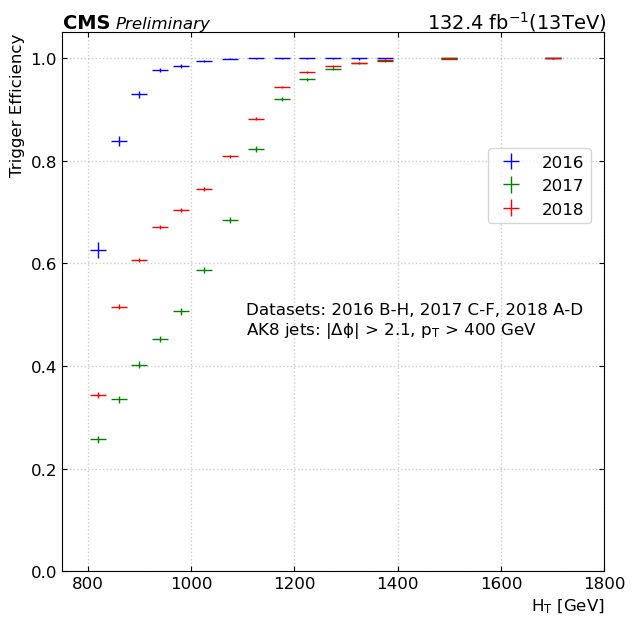

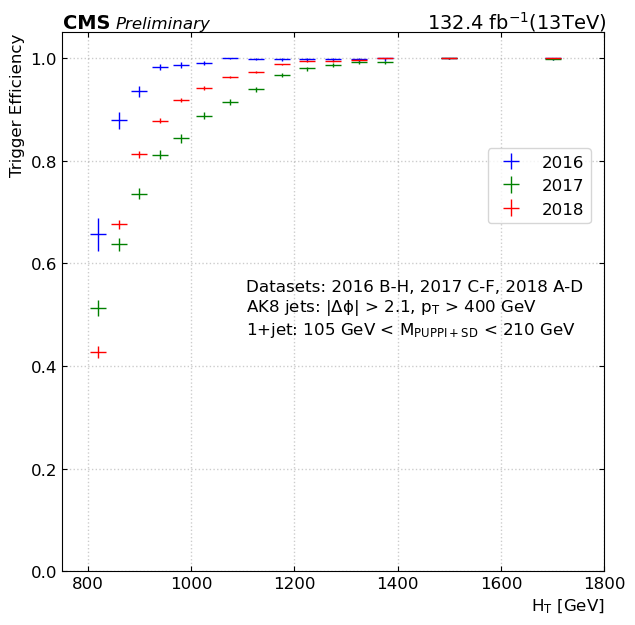

In [19]:
# Numerator1 = Data_num['condition1_numerator']['SingleMu'+year+'_Data', cat, :, sum]
# Denominator = Data_num['condition_denominator']['SingleMu'+year+'_Data', cat, :, sum]

for cat in ttagcats:
    #---- Histogram Window Config. ----# 
    plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
    })
    
    fig, ax = plt.subplots(
        nrows=1,
        ncols=1,
        figsize=(7,7),
        #sharey=True
        sharex=True
    )
    
    fig.subplots_adjust(hspace=.07)
    
    Denominator_2016 = Data_out_2016['condition_denominator']['SingleMu2016_Data', cat, :, sum, sum]
    Denominator_2017 = Data_out_2017['condition_denominator']['SingleMu2017_Data', cat, :, sum, sum]
    Denominator_2018 = Data_out_2018['condition_denominator']['SingleMu2018_Data', cat, :, sum, sum]
    
    Numerator_2016 = Data_out_2016['condition4_numerator']['SingleMu2016_Data', cat, :, sum, sum]
    Numerator_2017 = Data_out_2017['condition4_numerator']['SingleMu2017_Data', cat, :, sum, sum]  #exculiding eraB
    #Numerator_2017 = Data_out_2017['condition2_numerator']['SingleMu2017_Data', cat, :, sum, sum] #inculiding eraB
    Numerator_2018 = Data_out_2018['condition3_numerator']['SingleMu2018_Data', cat, :, sum, sum]
    
    EffPlot_2016 = plotratio(Numerator_2016, Denominator_2016, ax, 'errorbar', '_', 12., 'b')
    EffPlot_2017 = plotratio(Numerator_2017, Denominator_2017, ax, 'errorbar', '_', 12., 'g')
    EffPlot_2018 = plotratio(Numerator_2018, Denominator_2018, ax, 'errorbar', '_', 12., 'r')
    
    print(Numerator_2016 / Denominator_2016.values())
    print(Numerator_2017 / Denominator_2017.values())
    print(Numerator_2018 / Denominator_2018.values())
 
    leg = ax.legend(labels=[r'2016',r'2017', r'2018'], bbox_to_anchor=(0.99, 0.8),fontsize = 12, loc='upper right')


    ax.set_xlim(750, 1800)
    ax.set_ylim(bottom=0., top=1.05)
    ax.set_ylabel('Trigger Efficiency', fontsize = 12, loc = "top")
    ax.set_xlabel('H$_{\mathrm{T}}$ [GeV]', fontsize = 12, loc = "right")
    ax.grid(axis="x", color="k", alpha=.2, linewidth=1, linestyle=":")
    ax.grid(axis="y", color="k", alpha=.2, linewidth=1, linestyle=":")
    ax.tick_params(direction='in', top=True, right=True)
    
    
#     Cat_legend_entry = None  #inculing 2017 EraB
#     if cat == 0:
#         Cat_legend_entry = "Datasets: 2016 B-H, 2017 B-F, 2018 A-D\nAK8 jets: ${\mathrm{|\Delta\phi|}}$ > 2.1, p${\mathrm{_T}}$ > 400 GeV"
#         fnc = '_noSD'
#     else:
#         Cat_legend_entry = "Datasets: 2016 B-H, 2017 B-F, 2018 A-D\nAK8 jets: ${\mathrm{|\Delta\phi|}}$ > 2.1, p${\mathrm{_T}}$ > 400 GeV \n1+jet: 105 GeV < M${\mathrm{_{PUPPI+SD}}}$ < 210 GeV"
#         fnc = '_SD'
        
    Cat_legend_entry = None  #exculing 2017 EraB
    if cat == 0:
        Cat_legend_entry = "Datasets: 2016 B-H, 2017 C-F, 2018 A-D\nAK8 jets: ${\mathrm{|\Delta\phi|}}$ > 2.1, p${\mathrm{_T}}$ > 400 GeV"
        fnc = '_noSD'
    else:
        Cat_legend_entry = "Datasets: 2016 B-H, 2017 C-F, 2018 A-D\nAK8 jets: ${\mathrm{|\Delta\phi|}}$ > 2.1, p${\mathrm{_T}}$ > 400 GeV \n1+jet: 105 GeV < M${\mathrm{_{PUPPI+SD}}}$ < 210 GeV"
        fnc = '_SD'
        
        
    leg2 = plt.text(0.34, 0.44, Cat_legend_entry,
                fontsize=12,
                style='normal',
                #horizontalalignment='right',
                #verticalalignment='top',
                transform=ax.transAxes
               )
    
    ax.text(0.002, 1.035, 'CMS',
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes,
        color='black', fontsize=14, fontweight='bold')
    
    ax.text(0.099, 1.030, 'Preliminary',
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes,
        color='black', fontsize=12, style='italic')
    
 #including 2017 eraB
#     ax.text(1.004, 1.039, '137.2 fb$^{-1} (13{\mathrm{TeV}}$)',
#         verticalalignment='top', horizontalalignment='right',
#         transform=ax.transAxes,
#         color='black', fontsize=14, style='normal')
    
#exculiding 2017 eraB
    ax.text(1.004, 1.043, '132.4 fb$^{-1} (13{\mathrm{TeV}}$)',
        verticalalignment='top', horizontalalignment='right',
        transform=ax.transAxes,
        color='black', fontsize=14, style='normal')
   
    filename = 'AllYearsTriggerEffs' + fnc +'_withoutB.png'
    plt.savefig(SaveDirectory4+filename, bbox_inches="tight")
    print(SaveDirectory4+filename)

                   ┌─────────────────────────────────────────────────────────┐
[-inf,   0) 0      │                                                         │
[   0,  25) 0.9465 │███                                                      │
[  25,  50) 0.9528 │███                                                      │
[  50,  75) 0.9611 │███                                                      │
[  75, 100) 0.9618 │███                                                      │
[ 100, 125) 0.9603 │███                                                      │
[ 125, 150) 0.9629 │███                                                      │
[ 150, 175) 0.969  │███                                                      │
[ 175, 200) 0.9903 │███▏                                                     │
[ 200, 225) 0.9956 │███▏                                                     │
[ 225, 250) 1      │███▏                                                     │
[ 250, 300) 1      │███▏                            

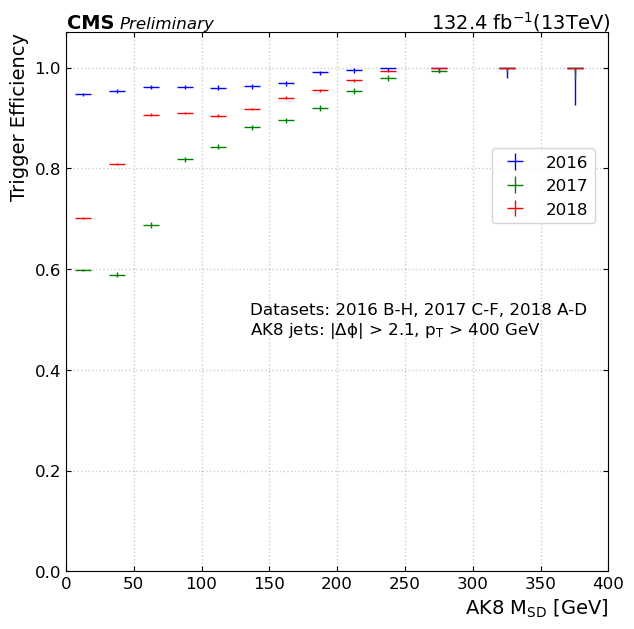

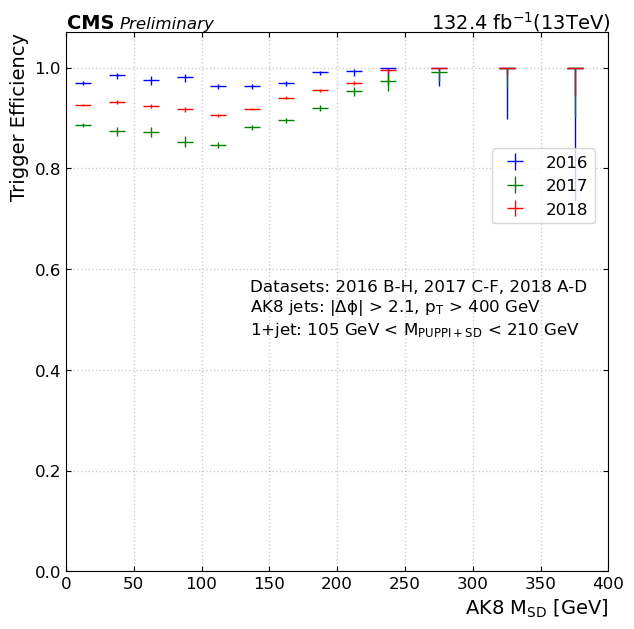

In [20]:
# Numerator1 = Data_num['condition1_numerator']['SingleMu'+year+'_Data', cat, :, sum]
# Denominator = Data_num['condition_denominator']['SingleMu'+year+'_Data', cat, :, sum]

for cat in ttagcats:
    #---- Histogram Window Config. ----# 
    plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
    })
    
    fig, ax = plt.subplots(
        nrows=1,
        ncols=1,
        figsize=(7,7),
        #sharey=True
        sharex=True
    )
    
    fig.subplots_adjust(hspace=.07)

    Denominator_2016 = Data_out_2016['condition_denominator']['SingleMu2016_Data', cat, sum, :, sum]
    Denominator_2017 = Data_out_2017['condition_denominator']['SingleMu2017_Data', cat, sum, :, sum]
    Denominator_2018 = Data_out_2018['condition_denominator']['SingleMu2018_Data', cat, sum, :, sum]
    
    Numerator_2016 = Data_out_2016['condition4_numerator']['SingleMu2016_Data', cat, sum, :, sum]
    Numerator_2017 = Data_out_2017['condition4_numerator']['SingleMu2017_Data', cat, sum, :, sum] #excluding eraB 
    #Numerator_2017 = Data_out_2017['condition2_numerator']['SingleMu2017_Data', cat, sum, :, sum] #including eraB
    Numerator_2018 = Data_out_2018['condition3_numerator']['SingleMu2018_Data', cat, sum, :, sum]
    
    EffPlot_2016 = plotratio(Numerator_2016, Denominator_2016, ax, 'errorbar', '_', 12., 'b')
    EffPlot_2017 = plotratio(Numerator_2017, Denominator_2017, ax, 'errorbar', '_', 12., 'g')
    EffPlot_2018 = plotratio(Numerator_2018, Denominator_2018, ax, 'errorbar', '_', 12., 'r')
    
    print(Numerator_2016 / Denominator_2016.values())
    print(Numerator_2017 / Denominator_2017.values())
    print(Numerator_2018 / Denominator_2018.values())
 
    leg = ax.legend(labels=[r'2016',r'2017', r'2018'], bbox_to_anchor=(0.99, 0.8),fontsize = 12, loc='upper right')


    ax.set_xlim(0, 400)
    ax.set_ylim(bottom=0., top=1.07)
    ax.set_ylabel('Trigger Efficiency', fontsize = 14, loc = "top")
    ax.set_xlabel('AK8 M$_{\mathrm{SD}}$ [GeV]', fontsize = 14, loc = "right")
    ax.grid(axis="x", color="k", alpha=.2, linewidth=1, linestyle=":")
    ax.grid(axis="y", color="k", alpha=.2, linewidth=1, linestyle=":")
    ax.tick_params(direction='in', top=True, right=True)
    
#     Cat_legend_entry = None #inculing 2017 EraB
#     if cat == 0:
#         Cat_legend_entry = "Datasets: 2016 B-H, 2017 B-F, 2018 A-D\nAK8 jets: ${\mathrm{|\Delta\phi|}}$ > 2.1, p${\mathrm{_T}}$ > 400 GeV"
#         fnc = '_noSD'
#     else:
#         Cat_legend_entry = "Datasets: 2016 B-H, 2017 B-F, 2018 A-D\nAK8 jets: ${\mathrm{|\Delta\phi|}}$ > 2.1, p${\mathrm{_T}}$ > 400 GeV \n1+jet: 105 GeV < M${\mathrm{_{PUPPI+SD}}}$ < 210 GeV"
#         fnc = '_SD'
        
    Cat_legend_entry = None  #exculing 2017 EraB
    if cat == 0:
        Cat_legend_entry = "Datasets: 2016 B-H, 2017 C-F, 2018 A-D\nAK8 jets: ${\mathrm{|\Delta\phi|}}$ > 2.1, p${\mathrm{_T}}$ > 400 GeV"
        fnc = '_noSD'
    else:
        Cat_legend_entry = "Datasets: 2016 B-H, 2017 C-F, 2018 A-D\nAK8 jets: ${\mathrm{|\Delta\phi|}}$ > 2.1, p${\mathrm{_T}}$ > 400 GeV \n1+jet: 105 GeV < M${\mathrm{_{PUPPI+SD}}}$ < 210 GeV"
        fnc = '_SD'
        
        
    leg2 = plt.text(0.34, 0.44, Cat_legend_entry,
                fontsize=12,
                style='normal',
                #horizontalalignment='right',
                #verticalalignment='top',
                transform=ax.transAxes
               )
    
    ax.text(0.002, 1.035, 'CMS',
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes,
        color='black', fontsize=14, fontweight='bold')
    
    ax.text(0.099, 1.030, 'Preliminary',
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes,
        color='black', fontsize=12, style='italic')
    
#including 2017 eraB
    # ax.text(1.004, 1.039, '137.2 fb$^{-1} (13{\mathrm{TeV}}$)',
    #     verticalalignment='top', horizontalalignment='right',
    #     transform=ax.transAxes,
    #     color='black', fontsize=14, style='normal')
    
#exculiding 2017 eraB
    ax.text(1.004, 1.043, '132.4 fb$^{-1} (13{\mathrm{TeV}}$)',
        verticalalignment='top', horizontalalignment='right',
        transform=ax.transAxes,
        color='black', fontsize=14, style='normal')
   
    filename = 'AllYearsTriggerEffs_MSD' + fnc +'_withoutB.png'
    plt.savefig(SaveDirectory4+filename, bbox_inches="tight")
    print(SaveDirectory4+filename)